In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
from datetime import date

In [3]:
df_customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-da-gerasimov/first_project/olist_customers_dataset.csv')
df_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-da-gerasimov/first_project/olist_orders_dataset.csv')
df_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-da-gerasimov/first_project/olist_order_items_dataset.csv')

Предобработка данных

In [279]:
df_orders.isnull().sum() ## Смотрим пропущенные значения

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [280]:
df_customers.isnull().sum() ## Смотрим пропущенные значения

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [281]:
df_items.isnull().sum() ## Смотрим пропущенные значения

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [282]:
df_customers.duplicated().value_counts() ## Смотрим дубли

False    99441
dtype: int64

In [283]:
df_items.duplicated().value_counts() ## Смотрим дубли

False    112650
dtype: int64

In [284]:
df_orders.duplicated().value_counts() ## Смотрим дубли

False    99441
dtype: int64

In [285]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp']) ## Переведем колонку в datetime
df_orders['order_approved_at'] = pd.to_datetime(df_orders['order_approved_at']) ## Переведем колонку в datetime

Задание 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Из всех статусов заказа в моем понимании покупкой считается статус заказа delivered и подтвержденное время оплаты товара.
Есть пропущенные значения в order_approved_at в одной строке со статусом заказа delivered, которые я не буду учитывать в покупки
Также есть пропущенные значения у order_delivered_carrier_date, order_delivered_customer_date. Я буду считать это ошибкой логирования.
Можно было бы просто дропнуть пропущенные значения, но мы оставим их.
Статус unavailable в моем понимании значит, что клиент оплатил заказ, но его не оказалось у продавца.

In [286]:
df_task_1 = df_customers.merge(df_orders) ## Джоиним данные

In [287]:
## Фильтруем данные по покупкам, группирруем по уникальному айди покупателя, считаем заказы, и фильтруем единичные заказы.
len(df_task_1.query('order_status == "delivered" & order_approved_at.notnull()')\
    .groupby('customer_unique_id') \
    .agg({'order_id':'count'}) \
    .query ('order_id == 1'))

90545

Задание 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Будем считать, что недоставленные заказы, это заказы со статусами : cancelled,unavailable. Можно было бы
считать, что те заказы, у которых нет даты доставки - это все недоставленные товары, но как по мне это нелогично.
Кроме того, надо перевести колонку order_purchase_timestamp в datetime, потому что по ней мы будем считать временные промежутки

In [288]:
## Создаем отдельный дф со всеми заказами у которых статус заказа не delivered
df_task_2 = df_orders.query('order_status == "canceled" | order_status == "unavailable"')

In [289]:
df_task_2['m_and_y_num'] = df_task_2['order_purchase_timestamp'].dt.strftime('%Y-%m') ## Создаем колонку с месяцем и годом

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [290]:
## Среднее количество недоставленных заказов в месяц
df_task_2.groupby(['m_and_y_num']) \
    .agg({'order_id':'count'})['order_id'].mean() 

51.416666666666664

In [291]:
## Строим таблицу с детализацей по годам,месяцам и причинам недоставленного заказа
df_task_2_table = df_task_2.groupby(['m_and_y_num','order_status'], as_index = False) \
    .agg({'order_id':'count'}) \
    .sort_values('m_and_y_num', ascending = True) \
    .pivot_table(values = 'order_id', columns = 'order_status', index = 'm_and_y_num',fill_value=0) 
df_task_2_table

order_status,canceled,unavailable
m_and_y_num,,
2016-09,2,0
2016-10,24,7
2017-01,3,10
2017-02,17,45
2017-03,33,32
2017-04,18,9
2017-05,29,31
2017-06,16,24
2017-07,28,52


In [292]:
## Первый и последний месяц имеют неполные данные, поэтому такой результат

Задание 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [293]:
df_task_3 = df_orders.merge(df_items, on = 'order_id') ## Джоиним заказы и детализацию по заказам

In [294]:
## Создаем колонку с днем недели, используем  дату создания заказа, т.к. это самая оптимальная колонка 
## для определения дня покупки, т.к подтверждение оплаты может прийти не сразу
df_task_3['day'] = df_task_3['order_purchase_timestamp'].dt.strftime('%a')

In [295]:
## Как уже выше определили используем фильтрацию для определения покупок, считаем для каждого товара количество покупок 
## в тот или иной день недели, ставим индекс day, чтобы idxmax работал правильно и получаем для каждого товара день недели,
## в который больше всего было куплено этого товара
df_task_3.query('order_status == "delivered" & order_approved_at.notnull()')\
    .groupby(['day','product_id']) \
    .agg({'order_id':'count'}) \
    .reset_index() \
    .set_index('day') \
    .rename(columns = {'order_id':'weekday'}) \
    .groupby('product_id', as_index = False) \
    .idxmax() \
    .head(5)

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sun
1,00088930e925c41fd95ebfe695fd2655,Tue
2,0009406fd7479715e4bef61dd91f2462,Thu
3,000b8f95fcb9e0096488278317764d19,Fri
4,000d9be29b5207b54e86aa1b1ac54872,Tue


Задание 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [296]:
df_task_4 = df_customers.merge(df_orders) ## Джоиним данные

In [297]:
df_task_4['period_m'] = df_task_4['order_approved_at'].dt.to_period('M')

In [298]:
## Фильтруем по покупкам
df_task_4 = df_task_4.query('order_status == "delivered" & order_approved_at.notnull()')

In [299]:
## Считаем покупки каждый месяц
df_task_4 = df_task_4.groupby(['customer_unique_id','period_m']) \
    .agg({'order_approved_at':'count'}) \
    .rename(columns = {'order_approved_at':'purchpermonth'}) \
    .reset_index()

In [300]:
## Функция для определения сколько дней в месяце
def numofdays (x):
        if x == 2:
            x = 28
        elif x == 4 or x==6 or x == 9 or x==11:
            x = 30
        else:
            x = 31
        return x 

In [301]:
## Применяем функцию
df_task_4['numofweeks'] = df_task_4['period_m'].apply(numofdays)/7

In [302]:
## Делаем колонку со средним значением покупок в неделю
df_task_4['purchperweek'] = df_task_4['purchpermonth']/df_task_4['numofweeks']
df_task_4.head(5)

,customer_unique_id,period_m,purchpermonth,numofweeks,purchperweek
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.428571,0.225806


Задание 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

In [303]:
## Создаем новый дф для удобства
df_merged_task_5 = df_orders.merge(df_customers) 

In [304]:
## Фильтруем покупки
df_merged_task_5 = df_merged_task_5.query('order_status == "delivered" & order_approved_at.notnull()') \

In [305]:
## Переводим колонку в значение год-месяц
df_merged_task_5['order_approved_at'] = df_merged_task_5['order_approved_at'].dt.strftime('%Y-%m')

In [306]:
## Определяем первый месяц покупки у каждого пользователя
users_min_month = df_merged_task_5.groupby('customer_unique_id',as_index = False) \
    .agg({'order_approved_at': 'min'})\
    .rename(columns = {'order_approved_at':'first_month'})

In [307]:
## Соединяем дфы
df_merged_task_5 = df_merged_task_5.merge(users_min_month)    

In [308]:
## Сортируем для удобства
df_merged_task_5 = df_merged_task_5.sort_values('order_approved_at')

In [309]:
## Считаем сколько пользователей совершили покупку в тот или иной месяц
df_merged_task_5 = df_merged_task_5.groupby(['first_month', 'order_approved_at']) \
    .agg({'customer_unique_id':'nunique'}) \
    .rename(columns = {'customer_unique_id':'cust_count'}) 

In [310]:
## Функция для опредения когорты
def cohort(df):
    df['cohort'] = np.arange(len(df)) + 1
    return df

df_merged_task_5= df_merged_task_5.groupby(level = 0).apply(cohort)

In [311]:
## Разворачиваем таблицу
df_merged_task_5 = df_merged_task_5.pivot_table(columns='cohort', index = 'first_month',values='cust_count')

In [312]:
## Создаем переменную для подсчета RR
first = df_merged_task_5[1]
retention = df_merged_task_5.divide(first, axis=0).round(5)

In [313]:
## Получаем наисвыший RR на 3 месяц
retention[3].idxmax()

'2017-09'

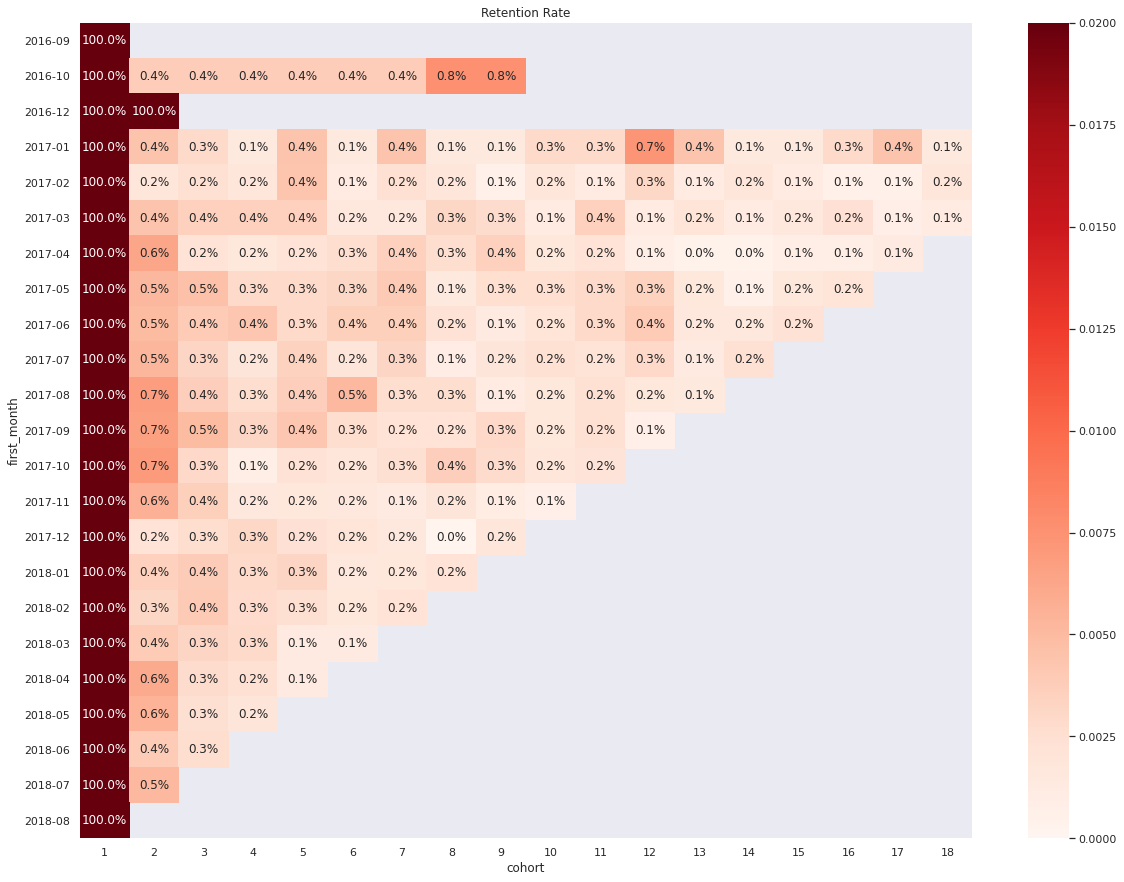

In [314]:
## Строим график
plt.figure(figsize=(20, 15))
sns.heatmap(retention, annot=True, fmt='.1%', cmap='Reds', vmin = 0, vmax = 0.02)
plt.title('Retention Rate')
plt.show()

 Задание 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю

In [315]:
## Джоиним дфы
df_data = df_orders.merge(df_items, on = 'order_id', how = 'inner')
df_full = df_data.merge(df_customers)

In [316]:
## Фильтруем по покупкам
df_full_task_6 = df_full.query('order_status == "delivered" & order_approved_at.notnull()')

In [317]:
## Группируем уникальный айди клиентов, считаем метрики: Monetary, Frequency
df_full_task_6_rfm = df_full_task_6.groupby('customer_unique_id') \
    .agg({'price' : 'sum',
          'order_id':'nunique'}) \
    .rename(columns = {'price':'Monetary','order_id':'Frequency'}) \
    .reset_index()

In [318]:
## Считаем последний день во всем датафрейме для метрики Recency
df_full_task_6['last_day'] = df_full_task_6['order_approved_at'].max()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [319]:
## Считаем метрику Recency в днях
df_full_task_6_rfm['Recency'] = (df_full_task_6['last_day'] - df_full_task_6['order_approved_at']).dt.days

In [320]:
## Видим ненормальное распределение
df_full_task_6_rfm['Frequency'].value_counts()

1     90545
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: Frequency, dtype: int64

In [321]:
## Для метрик R и M считаем кванитили по которым разобьем на группы клиентов
quintiles = df_full_task_6_rfm[['Recency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

{'Recency': {0.2: 95.0, 0.4: 179.0, 0.6: 269.0, 0.8: 382.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [322]:
## Для метрик R и M делаем функции, для R получается: чем меньше дней, тем лучше(5), для M наоборот. Для F делаем другую функцию,
## т.к. через квантили не получается разделить эту метрику на группы.
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['Monetary'][.2]:
        return 1
    elif x <= quintiles['Monetary'][.4]:
        return 2
    elif x <= quintiles['Monetary'][.6]:
        return 3
    elif x <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5
    
def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    else:
        return 3 

In [323]:
## Делаем колонки с оценками по метрикам
df_full_task_6_rfm['R'] = df_full_task_6_rfm['Recency'].apply(lambda x: r_score(x))
df_full_task_6_rfm['F'] = df_full_task_6_rfm['Frequency'].apply(lambda x: f_score(x))
df_full_task_6_rfm['M'] = df_full_task_6_rfm['Monetary'].apply(lambda x: m_score(x))

In [324]:
## Делаем колонку Score
df_full_task_6_rfm['RFM_Score'] = df_full_task_6_rfm['R'].map(str) + df_full_task_6_rfm['F'].map(str) + df_full_task_6_rfm['M'].map(str)

In [325]:
## Сегментируем  пользователей по RF, M не будем учитывать.
segt_map = {
    r'11': 'hibernating',
    r'1[2-3]': 'can\'t loose',
    r'[2-3]1': 'about to sleep',
    r'[2-3][2-3]': 'need attention',
    r'4[2-3]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'52': 'potential сhampions',
    r'53': 'champions'
}
df_full_task_6_rfm['Segment'] = df_full_task_6_rfm['R'].map(str) + df_full_task_6_rfm['F'].map(str)
df_full_task_6_rfm['Segment'] = df_full_task_6_rfm['Segment'].replace(segt_map, regex=True)
df_full_task_6_rfm.head(5)

,customer_unique_id,Monetary,Frequency,Recency,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,331.0,2,1,4,214,about to sleep
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,34.0,5,1,1,511,new customers
2,0000f46a3911fa3c0805444483337064,69.00,1,21.0,5,1,2,512,new customers
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,283.0,2,1,1,211,about to sleep
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,196.0,3,1,5,315,about to sleep
